In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'
# path_to_git = '/home/kentaro/github/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

dict_keys(['W', 'window_start_ids', 'D', 'Ddose', 'Dname', 'Pobs', 'Pname', 'C', 'Cname', 'Y', 'Yname', 'cluster', 'sids', 'pseudoMRNs'])

In [70]:
iic_burden['Cname']

['Gender',
 'Age',
 'marrital',
 'APACHE II  first 24',
 'Hx CVA (including TIA)',
 'Hx HTN',
 'Hx Sz /epilepsy',
 'Hx brain surgery',
 'Hx CKD',
 'Hx CAD/MI',
 'Hx CHF',
 'Hx DM',
 'Hx of HLD',
 'Hx tobacco (including ex-smokers)',
 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)',
 'Hx other substance abuse, any time in their life',
 'Hx cancer (other than CNS cancer)',
 'Hx CNS cancer',
 'Hx COPD/ Asthma',
 'premorbid MRS before admission  (modified ranking scale),before admission',
 'SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)',
 'hydrocephalus  (either on admission or during hospital course)   QPID',
 'iMV  (initial (on admission) mechanical ventilation)',
 'systolic BP',
 'diastolic BP',
 'Midline shift with any reason ( Document Date)',
 'Primary systemic dx Sepsis/Shock',
 'iGCS-Total',
 'iGCS = T?',
 'iGCS-E',
 'iGCS-V',
 'iGCS-M',
 'W

In [9]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

## Controlling for age

In [169]:
m_dict_dict = {}
cates_dict_dict = {}

for type_summary in tqdm.tqdm(['max']):#,'mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Age', 'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 4
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
    num = []
    n_thresholds = 5
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] >= threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 5
        n_splits = 2
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts.drop(columns=['mRS','E','lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full')
        
        # storing the malts object
        m_dict[threshold] = m
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)

#         mg = m.MG_matrix
#         cates = [] # cate of unit for a given summary fn, at a given threshold
#         for i in mg.index:
#             mgi = mg.loc[i]
#             try:
#                 mgi_units = mgi.loc[mgi>(n_repeats*n_splits//2)-1].index
#                 df_mgi = df_malts.drop(columns=['mRS','E']).loc[mgi_units][['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate','T','Y']]
#                 df_mgi_ind = df_mgi[['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']]>0
#                 df_mgi = df_mgi_ind.join(df_mgi, lsuffix= '_given' )
#                 df_mgi2 = df_mgi[['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']]**2
#                 df_mgi = df_mgi.join(df_mgi2, rsuffix= '$^2$' )
#                 model = lm.LinearRegression().fit(df_mgi.drop(columns=['Y']),df_mgi['Y'])
#                 cates.append( model.coef_.reshape(-1,) )
#             except:
#                 continue
#         cates = pd.DataFrame(np.array(cates),index=mg.index,columns=df_mgi.drop(columns=['Y']).columns)
#         df_malts_res = df_malts.join(cates,rsuffix='_coef')
#         cates_dict[threshold] = df_malts_res
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict


100%|██████████| 1/1 [05:29<00:00, 329.28s/it]


In [170]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_m_atec = pd.DataFrame( np.array([m_dict[threshold].CATE_df.loc[m_dict[threshold].CATE_df['T']==0].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['%.2f'%(j) for j in m_dict.keys()], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

<AxesSubplot:>

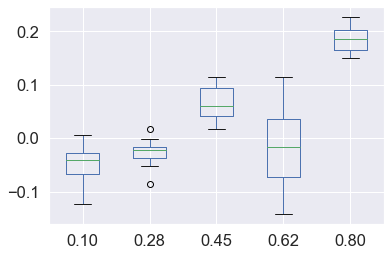

In [171]:
df_m_atec.T.plot(kind='box')

# Controlling for all pre-admission covariates

In [157]:
m_dict_dict = {}
cates_dict_dict = {}

for type_summary in tqdm.tqdm(['max']):#,'mean','proportion']):
    df_coarsen = setup_coarsen_data(iic_burden,window = 36,summarize=type_summary,threshold=0.1)
    df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                               'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                               'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                               'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                               'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                               'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                               'Hx CNS cancer', 'Hx COPD/ Asthma', 
                               'premorbid MRS before admission  (modified ranking scale),before admission', 
                               'hydrocephalus  (either on admission or during hospital course)   QPID', 
                               'iMV  (initial (on admission) mechanical ventilation)',
                               'Primary systemic dx Sepsis/Shock', 'iGCS-Total', 
                               'iGCS actual scores', 'Worst GCS in 1st 24',
                               'Worst GCS Intubation status',
                               'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                               'mRS', 'E'
                               ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

    
    baseline_threshold = 0.1
    df_coarsen_1['Y'] = df_coarsen_1['mRS'] > 4
    df_coarsen_baseline = df_coarsen_1.loc[df_coarsen_1['E']<baseline_threshold]
    num_control = df_coarsen_baseline.shape[0]
    
    num = []
    n_thresholds = 5
    thresholds = list(np.linspace(baseline_threshold,0.8,num=n_thresholds)) + [1.0001]
    
    m_dict = {}
    cates_dict = {}
    
    for i in tqdm.tqdm(range(0,n_thresholds)):
        # setting up the data
        threshold = thresholds[i]
        upper_threshold = thresholds[i+1]
        
        df_coarsen_comparison = df_coarsen_1.loc[df_coarsen_1['E'] >= threshold]
        df_coarsen_comparison = df_coarsen_comparison.loc[df_coarsen_comparison['E']<upper_threshold] #T=1 if threshold <= E < upper_threshold
        num_treated = df_coarsen_comparison.shape[0]
        
        df_malts = df_coarsen_comparison.append(df_coarsen_baseline)
        
        df_malts['T'] = df_malts['E'] >= threshold
        
        # malts object, match only on pre-treatment covariates
        n_repeats = 5
        n_splits = 2
        m = pm.malts_mf(outcome='Y',
                        treatment='T', 
                        data=df_malts.drop(columns=['mRS','E','lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']),
                        n_repeats=n_repeats,
                        n_splits=n_splits,
                        output_format='full')
        
        # storing the malts object
        m_dict[threshold] = m
        
        # saving configuration 
        num = num + ['%.2f\n(%d,%d)'%(threshold,num_treated,num_control)]
        # summary name appended with current level of threshold
        name = type_summary + str(threshold)

#         mg = m.MG_matrix
#         cates = [] # cate of unit for a given summary fn, at a given threshold
#         for i in mg.index:
#             mgi = mg.loc[i]
#             try:
#                 mgi_units = mgi.loc[mgi>(n_repeats*n_splits//2)-1].index
#                 df_mgi = df_malts.drop(columns=['mRS','E']).loc[mgi_units][['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate','T','Y']]
#                 df_mgi_ind = df_mgi[['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']]>0
#                 df_mgi = df_mgi_ind.join(df_mgi, lsuffix= '_given' )
#                 df_mgi2 = df_mgi[['lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']]**2
#                 df_mgi = df_mgi.join(df_mgi2, rsuffix= '$^2$' )
#                 model = lm.LinearRegression().fit(df_mgi.drop(columns=['Y']),df_mgi['Y'])
#                 cates.append( model.coef_.reshape(-1,) )
#             except:
#                 continue
#         cates = pd.DataFrame(np.array(cates),index=mg.index,columns=df_mgi.drop(columns=['Y']).columns)
#         df_malts_res = df_malts.join(cates,rsuffix='_coef')
#         cates_dict[threshold] = df_malts_res
        
    m_dict_dict[type_summary] = m_dict
    cates_dict_dict[type_summary] = cates_dict





100%|██████████| 1/1 [11:42<00:00, 702.52s/it]


In [167]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_m_atec = pd.DataFrame( np.array([m_dict[threshold].CATE_df.loc[m_dict[threshold].CATE_df['T']==0].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['%.2f'%(j) for j in m_dict.keys()], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

<AxesSubplot:>

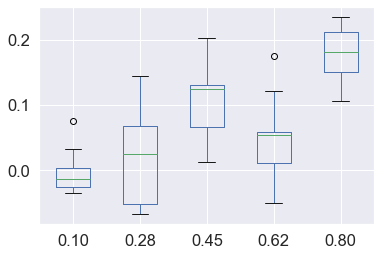

In [168]:
df_m_atec.T.plot(kind='box')

Text(0.5, 0, 'mRS')

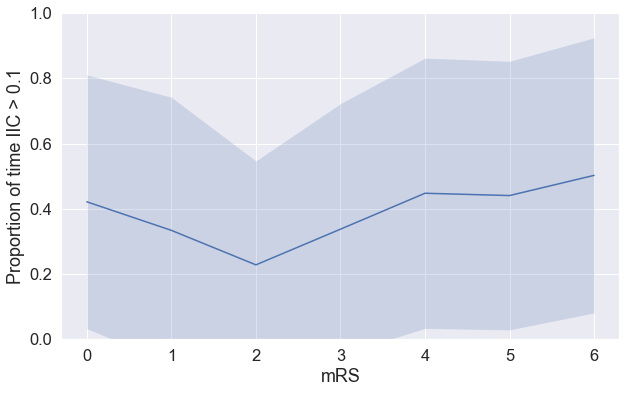

In [27]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10,6))
plt.plot(df_coarsen_1.groupby(by='mRS')['E'].mean())
plt.fill_between(df_coarsen_1.groupby(by='mRS')['E'].mean().index,
                 df_coarsen_1.groupby(by='mRS')['E'].mean()+df_coarsen_1.groupby(by='mRS')['E'].std(),
                 df_coarsen_1.groupby(by='mRS')['E'].mean()-df_coarsen_1.groupby(by='mRS')['E'].std(),
                alpha=0.2)
plt.ylim(0,1)
plt.ylabel('Proportion of time IIC > 0.1')
plt.xlabel('mRS')